[CGB] Epoch 10/500, Loss=1.3888, mu2=0.393, sigma2=1.359
[CGB] Epoch 20/500, Loss=1.2519, mu2=0.804, sigma2=1.096
[CGB] Epoch 30/500, Loss=1.1217, mu2=1.227, sigma2=0.847
[CGB] Epoch 40/500, Loss=0.9743, mu2=1.672, sigma2=0.334
[CGB] Epoch 50/500, Loss=0.9011, mu2=1.937, sigma2=0.344
[CGB] Epoch 60/500, Loss=0.8963, mu2=1.934, sigma2=0.327
[CGB] Epoch 70/500, Loss=0.8887, mu2=1.930, sigma2=0.227
[CGB] Epoch 80/500, Loss=0.8911, mu2=1.932, sigma2=0.276
[CGB] Epoch 90/500, Loss=0.8916, mu2=1.937, sigma2=0.319
[CGB] Epoch 100/500, Loss=0.8859, mu2=1.933, sigma2=0.135
[CGB] Epoch 110/500, Loss=0.8896, mu2=1.936, sigma2=0.314
[CGB] Epoch 120/500, Loss=0.8907, mu2=1.930, sigma2=0.196
[CGB] Epoch 130/500, Loss=0.8918, mu2=1.936, sigma2=0.147
[CGB] Epoch 140/500, Loss=0.8904, mu2=1.926, sigma2=0.317
[CGB] Epoch 150/500, Loss=0.8924, mu2=1.932, sigma2=0.259
[CGB] Epoch 160/500, Loss=0.8894, mu2=1.933, sigma2=0.296
[CGB] Epoch 170/500, Loss=0.8880, mu2=1.939, sigma2=0.153
[CGB] Epoch 180/500, Lo

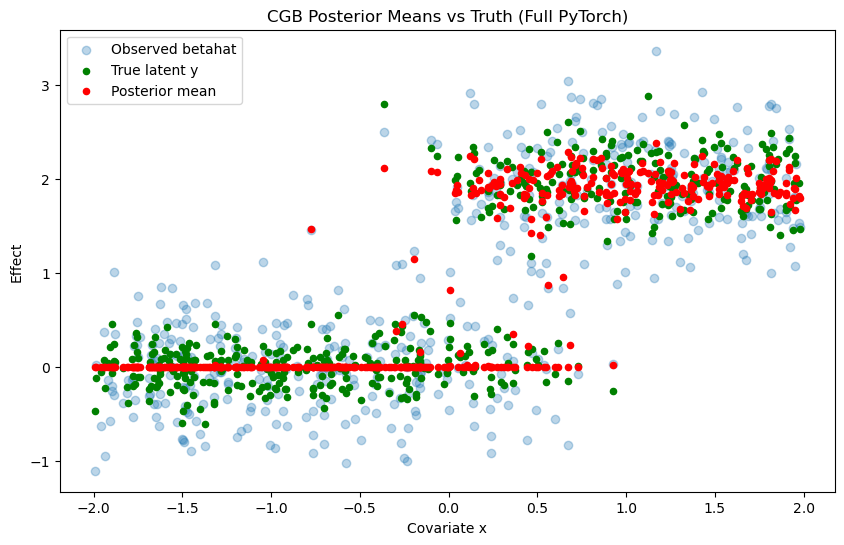

MSE(post_mean, y) = 0.0566
MSE(post_mean, y) = 0.1633
Learned μ2 ≈ 1.942  (true 2.0)
Learned σ2 ≈ 0.268  (true 0.3)


In [25]:

import math
import torch
import matplotlib.pyplot as plt
#from torch.utils.data import Dataset, DataLoader
from cebmf_torch.torch_cebnm.cov_gb_prior import cgb_posterior_means   # adjust path if solver file has another name


torch.manual_seed(12)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N = 500
a, b = 5.0, -1.0
mu1_true, sig1_true = 0.0, 0.2
mu2_true, sig2_true = 2.0, 0.3
sd_noise = .4

x = torch.empty(N, device=device).uniform_(-2.0, 2.0)    # (N,)
pi2_true = torch.sigmoid(a * x + b)                      # (N,)
pi1_true = 1.0 - pi2_true

# sample component and latent y
comp = torch.bernoulli(pi2_true).to(dtype=torch.int64)   # 1 -> slab, 0 -> spike-at-0-plus-noise
y = torch.empty(N, device=device)
y[comp == 0] = torch.normal(mean=mu1_true, std=sig1_true, size=(int((comp == 0).sum()),), device=device) 
y[comp == 1] = torch.normal(mean=mu2_true, std=sig2_true, size=(int((comp == 1).sum()),), device=device) 

# observed betahat = y + obs noise
betahat    = y + torch.normal(mean=0.0, std=sd_noise, size=(N,), device=device)
sebetahat  = torch.full((N,), sd_noise, dtype=torch.float32, device=device)

# =======================
# Fit & evaluate
# =======================
res =cgb_posterior_means(
    x, betahat, sebetahat, n_epochs=500, lr=1e-2, penalty=1.1
)

# Move to CPU for plotting / numpy ops
x_cpu         = x.detach().cpu()
betahat_cpu   = betahat.detach().cpu()
y_cpu         = y.detach().cpu()
post_mean_cpu = res.post_mean.detach().cpu()

# Plot
plt.figure(figsize=(10,6))
plt.scatter(x_cpu, betahat_cpu, alpha=0.3, label="Observed betahat")
plt.scatter(x_cpu, y_cpu, c="green", s=20, label="True latent y")
plt.scatter(x_cpu, post_mean_cpu, c="red", s=20, label="Posterior mean")
plt.xlabel("Covariate x"); plt.ylabel("Effect")
plt.title("CGB Posterior Means vs Truth (Full PyTorch)")
plt.legend(); plt.show()

mse = torch.mean((res.post_mean - y).pow(2)).item()
mse_noise = torch.mean((betahat - y).pow(2)).item()
print(f"MSE(post_mean, y) = {mse:.4f}")
print(f"MSE(post_mean, y) = {mse_noise:.4f}")
print(f"Learned μ2 ≈ {res.mu_2:.3f}  (true {mu2_true})")
print(f"Learned σ2 ≈ {res.sigma_2:.3f}  (true {sig2_true})")


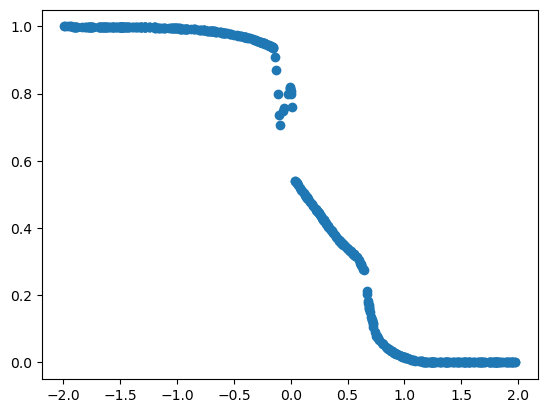

In [26]:
plt.scatter(x_cpu,res.pi)